# FMRI Preprocessing Pipeline
Via EEG/FMRI Naturalistic Viewing Dataset (Natview): Resting State

In [1]:
# connecting to natview dataset
from dotenv import load_dotenv
import os

load_dotenv()
DATA_PATH = os.getenv("HPC_NATVIEW_PATH")

In [3]:
# grabbing 22 subjects
rawdata_path = f"{DATA_PATH}/rawdata"
subjects = [f"{rawdata_path}/sub-{i:02d}" for i in range(1, 23)]
test_sub = subjects[0] # subject 01, i.e. 'sub-01'
test_sub

'/Users/maggiezhang/hpc-lab/Projects/Hypergraphsciousness/datasets/natview/rawdata/sub-01'

## Visualizing Schaefer Atlas

In [4]:
from nilearn import datasets
from nilearn.plotting import plot_roi, plot_stat_map, show

# Schaefer 2018: 200 ROIs, 7 Yeo networks, 2mm (matches typical fMRI)
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
atlas_img = schaefer.maps
print(f"Atlas: {atlas_img}")
print(f"Labels (first 5): {schaefer.labels[:5]}")

[fetch_atlas_schaefer_2018] Dataset found in /Users/maggiezhang/nilearn_data/schaefer_2018
Atlas: /Users/maggiezhang/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
Labels (first 5): ['Background', '7Networks_LH_Vis_1', '7Networks_LH_Vis_2', '7Networks_LH_Vis_3', '7Networks_LH_Vis_4']


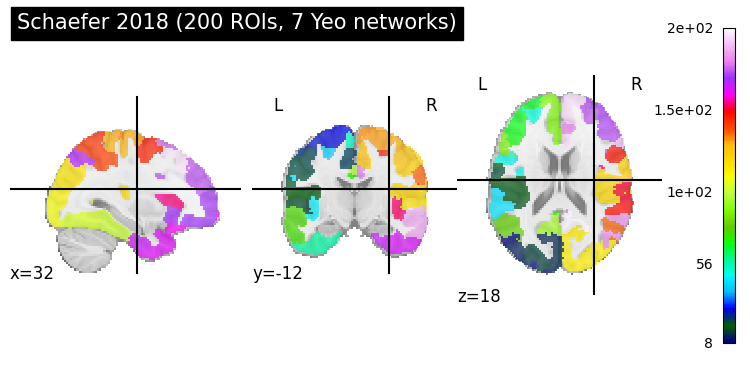

In [5]:
# Plot Schaefer atlas (ROI boundaries)
plot_roi(atlas_img, title="Schaefer 2018 (200 ROIs, 7 Yeo networks)", colorbar=True)
show()

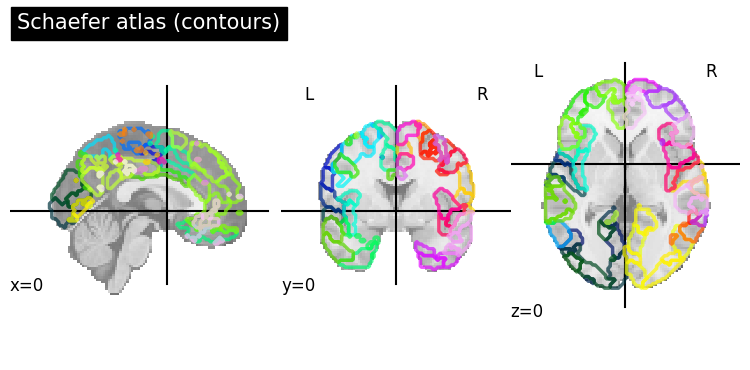

In [ ]:
# Plot with contours
plot_roi(atlas_img, view_type="contours", title="Schaefer atlas (contours)")
show()

## Load task-rest BOLD and visualize via Schaefer (timeseries + connectome)

In [7]:
import glob
from pathlib import Path

# Find task-rest BOLD in NatView derivatives (BIDS: sub-XX/func/*task-rest*bold*.nii.gz)
func_dir = Path(test_sub) / "ses-01"/ "func"
rest_files = sorted(glob.glob(str(func_dir / "*task-rest*bold*.nii.gz")))
if not rest_files:
    # try ses-* if present
    rest_files = sorted(glob.glob(str(Path(test_sub) / "ses-*" / "func" / "*task-rest*bold*.nii.gz")))
bold_path = rest_files[0] if rest_files else None
print(f"Task-rest BOLD: {bold_path}")

Task-rest BOLD: /Users/maggiezhang/hpc-lab/Projects/Hypergraphsciousness/datasets/natview/rawdata/sub-01/ses-01/func/sub-01_ses-01_task-rest_bold.nii.gz


In [ ]:
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

if bold_path is None:
    print("No task-rest BOLD found. Check DATA_PATH and subject folder structure.")
else:
    masker = NiftiLabelsMasker(
        labels_img=atlas_img,
        standardize="zscore_sample",
        memory="nilearn_cache",
        verbose=0,
    )
    timeseries = masker.fit_transform(bold_path)  # (n_timepoints, n_rois)
    print(f"Timeseries shape: {timeseries.shape}")

/var/folders/1n/809pcjmx44b3l32bjllkm4c00000gn/T/ipykernel_6701/2951037393.py:13: UserWarning: After resampling the label image to the data image, the following labels were removed: {np.float32(162.0), np.float32(163.0), np.float32(5.0), np.float32(7.0), np.float32(9.0), np.float32(106.0), np.float32(11.0), np.float32(108.0), np.float32(13.0), np.float32(14.0), np.float32(111.0), np.float32(112.0), np.float32(114.0), np.float32(57.0), np.float32(59.0)}. Label image only contains 186 labels (including background).
  timeseries = masker.fit_transform(bold_path)  # (n_timepoints, n_rois)


Timeseries shape: (288, 185)
